<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Review-of-Related-Literature" data-toc-modified-id="Review-of-Related-Literature-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Review of Related Literature</a></span></li><li><span><a href="#Experimental-Design" data-toc-modified-id="Experimental-Design-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experimental Design</a></span><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-&amp;-Data-Organization" data-toc-modified-id="Exploratory-Data-Analysis-&amp;-Data-Organization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Exploratory Data Analysis &amp; Data Organization</a></span></li><li><span><a href="#Uplift-Model-Evaluation-Metrics" data-toc-modified-id="Uplift-Model-Evaluation-Metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Uplift Model Evaluation Metrics</a></span></li></ul></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baseline Model</a></span></li><li><span><a href="#Causal-Network-Algorithm" data-toc-modified-id="Causal-Network-Algorithm-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Causal Network Algorithm</a></span></li><li><span><a href="#Dragonnet" data-toc-modified-id="Dragonnet-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Dragonnet</a></span></li><li><span><a href="#CEVAE" data-toc-modified-id="CEVAE-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CEVAE</a></span></li></ul></li><li><span><a href="#Tune-Parameters" data-toc-modified-id="Tune-Parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tune Parameters</a></span><ul class="toc-item"><li><span><a href="#Baseline-Model-Tuning" data-toc-modified-id="Baseline-Model-Tuning-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Baseline Model Tuning</a></span></li><li><span><a href="#Causal-Network-Tuning" data-toc-modified-id="Causal-Network-Tuning-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Causal Network Tuning</a></span></li><li><span><a href="#Dragonnet-Tuning" data-toc-modified-id="Dragonnet-Tuning-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Dragonnet Tuning</a></span></li></ul></li><li><span><a href="#Empirical-Results" data-toc-modified-id="Empirical-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Empirical Results</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [3]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys,time,random,warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
import utils

# Causalml
import causalml
print(causalml.__version__)

from causalml.metrics.visualize import *
from causalml.propensity import calibrate

import logging
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

# Benchmark
from xgboost import XGBRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor, BaseTRegressor #TMLELearner

# Causal net
import causal_nets
from causal_nets import causal_net_estimate

# Dragonnet
from causalml.inference.nn import DragonNet

# CEVAE 
from causalml.inference.nn import CEVAE

#import torch
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

# Tuning
#from bayes_opt import BayesianOptimization #Cannot work
from sklearn.model_selection import GridSearchCV

# Self-defined functions and codes that are omitted because of long running time
# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

0.10.0


# Introduction


Uplift models are popular methods to support marketing decision-making problems. With uplifts models marketing analysts are able to estimate the causal effect of marketing treatment on consumer behavior. Consider the example of an e-mail campaign that aims to send digital discount codes to customers as an incentive for the customers to buy, and thus, to e.g. drive sales revenues. The causal effect of the price discount is the treatment effect. It quantifies the change in customer’s buying probability due to the marketing activity (i.e. the price discount). Estimating the causal effect of a marketing activity is crucial to for instance evaluate the true impact of a marketing campaign.

It is important to carefully decide which customers should receive treatments. As shown in the adapted *Figure 1* by Devriendt et al. (2018), customers can be assigned into four targeting groups based on whether a customer responds when treated or not treated: sure things, lost causes, persuadables, and do-not-disturbs. Uplift models should predict the persuadables. Based on data from which we can observe whether a customer was targeted and whether the customer responded, we want to get the information of those customers who responded because we targeted (i.e. treated) them with our marketing activity (Kane et al., 2014). As discussed by Lai (2006) and Kane et al. (2014) customers can be grouped further into four categories: Control responders, treatment nonresponders, control nonresponders and treatment responders. The latter two are labeled as positive lifts because they contain all persuadables (positive targets, i.e. customers who respond only if they are targeted), whereas the first two are considered as negative lifts. Thus, uplift models must identify those customers who have no initial intention to buy but can be influenced to buy because we target them, which essentially implies causality. With this we can avoid for example negative profit by targeting the wrong customers. Devriendt et al. (2018) give a comprehensive overview of the state-of-the-art in uplift modeling.

<div>
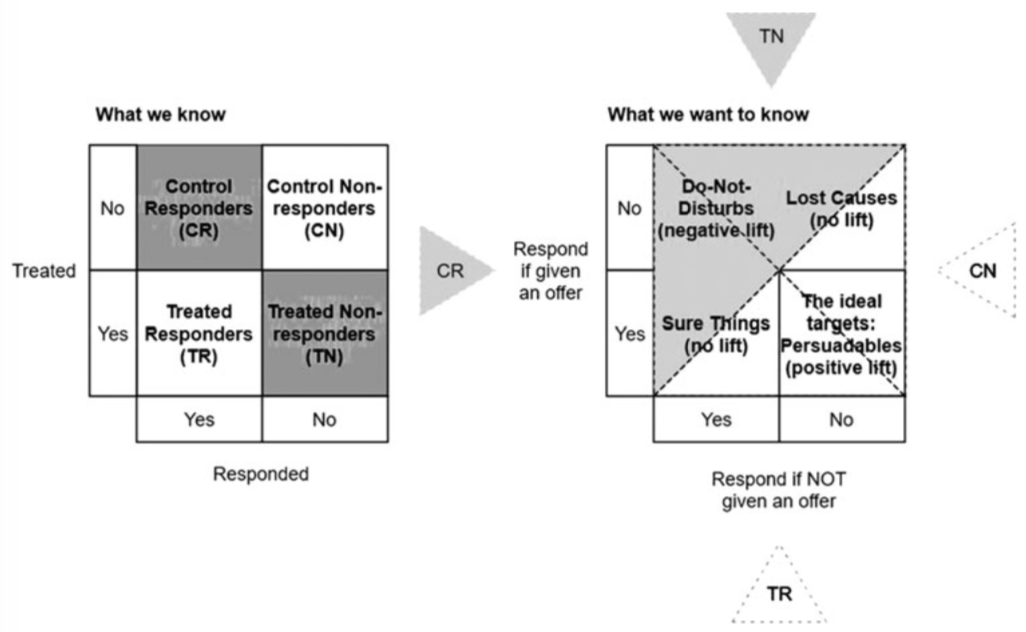
</div>

                                             Figure 1: Conceptual table. (Devriendt, Moldovan and Verbeke, 2018)




  
The uplift (Devriendt et al., 2018) is considered as the impact of the treatment or respectively the difference in behavior of customers due to the marketing activity (e.g. discount, newsletter). The uplift $U(x_i)$ is defined as the probability of a customer to respond if treated minus the probability of the customer to respond when not treated.:  
\begin{equation} U(x_i): = p(Y_i | X_i, T_i = 1) -  p(Y_i | X_i, T_i = 0) , \end{equation}  
where $T$ denotes the treatment variable, $Y$ the target , $X$ the features and $p$ the probability estimated by a model.  


There exists different types of the treatment effects. Here we just briefly mention the parameters that are of our interests.  

The Individual Treatment Effect (ITE): 
\begin{equation} \tau^{ITE} = \tau_i = Y_i(1) - Y_i(0) \end{equation}   
The Conditional Average Treatment Effect (CATE), which is the individual or group-level effect of the treatment: \begin{equation} \tau^{CATE} = \tau(x) = E(Y_i(1) - Y_i(0) | X_i = x_i) \end{equation}  
The Average Treatment Effect (ATE), which is the overall effect of the treatment of the customers:  
\begin{equation} \tau^{ATE} = E(\tau(x)) = E(Y_i(1) - Y_i(0)) \end{equation}   
 

The aim of this notebook is to exploit different methods of neural networks for the estimation of treatment effects in an uplift modeling setting and in a marketing context. For this we use the data of an e-mail marketing campaign provided by Hillstrom (Hillstrom, 2008). The notebook is structured as the following. In the first section we give a more comprehensive overview of recent neural network based on treatment effect estimation approaches and introduce evaluation metrics. In the next section a descriptive analysis introduces the underlying dataset for targeting marketing campaigns. Then we give implementation details on baseline model and three neural network based models in an uplift modeling setting, followed by an analysis and evaluation to compare their performances. Lastly, we summarize the results of our project and discuss possible limitations and provide an outlook.   

# Review of Related Literature

In recent years, more and more researchers focus on treatment effect estimation. Recent works have also looked into how machine learning method can help to detect treatment effects. But it has been used in this field many years ago. Lo(2002) estimates the uplift in a market experimental dataset, with two estimators, a logistic regression model and a neural network. Shalit et al.(2016) applies an algorithm based on a two-headed neural network model estimating ITE to give a generalization-error bound, which is known as TARNet. 

In the same year, Louizos et al.(2017) proposes a new model also for estimating ITE, which is based on Variational Autoencoders following the causal structure of inference with proxies. Farrell et al.(2018) uses ReLU as activation function $\sigma(x)=max(x,0)$ to construct a feedforward neural network. ATE is used for evaluationg the treatment effect. Shi et al.(2019a) introduces DargonNet, which is three-head lead neural network architecture. It uses representation learning ideas for treatment effect estimation and exploits the sufficiency of the propensity score. Further works in recent years have related to deep neural network. Farajtabar et al.(2020) advocates balance regularization of multi-head neural network architectures.

In our paper, we use the following algorithms to train our data: causal network algorithm from Farrell et al.(2018), DragonNet from Shi et al.(2019a) and CEVAE from Louizos et al.(2017). The first two are delicately studied, but for the last one we just roughly analyse this problem to add a additional concept in our project.

# Experimental Design

This section gives an overview of the dataset E-Mail Analytics And Data Mining Challenge by Hillstrom (2008). We do some exploratory data analysis and prepare the dataset. 

## Exploratory Data Analysis & Data Organization

We choose `Kevin Hillstrom` as our data, which is from E-Mail Analytics And Data Mining Challenge (Hillstrom 2008). The dataset consists of records reflecting customers that last purchased within 12 months.

In [4]:
# APA_M1_data is an open repository for the store of the results or functions that we used in this assignment

url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/Hillstrom.csv'
test = pd.read_csv(url) 

test.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [5]:
# Query some properties of the known data

print('Dimensionality of the known data is {}'.format(test.shape))  # .shape returns a tupel
print('The known data set has {} cases.'.format(test.shape[0]))     # we can also index the elements of that tupel
print('The total number of elements is {}.'.format(test.size))

Dimensionality of the known data is (64000, 12)
The known data set has 64000 cases.
The total number of elements is 768000.


In the data set, we have 64,000 observations in 12 columns, which represents customers' features, treatment and their responses. 

There is no null values. So we could use the data without dealing with missing value. Next step, we would see more details of the data.

Among the 12 columns, there are three possible targets. 

- Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.

- Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.

- Spend: Actual dollars spent in the following two weeks.

As a prototype, we firstly choose `conversion` as our target. As for `conversion`: on the one hand, it makes more sense than `visit`, because it shows customers's real reaction to treatment, though its response size is smaller than `visit`; on the other hand, `conversion` is a binary variable, it can fit many methods. As for `spend`, it shows actual dollars that the customers spent, which is also meaningful to be a target variable. However, some algorithms that we choose cannot be used for continuous target. Thus, the only target variable in our paper is `conversion`.

Concerning the indicator of treatment, `segment` is appropriate. There are three levels: 

- Mens E-Mail

- Womens E-Mail

- No E-Mail

Then the regressor may contain the following:

- Recency: Months since last purchase.

- History: Actual dollar value spent in the past year.

- Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.

- Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.

- Zip_Code: Classifies zip code as Urban, Suburban, or Rural.

- Newbie: 1/0 indicator, 1 = New customer in the past twelve months.

- Channel: Describes the channels the customer purchased from in the past year.

`History_Segment` could be deleted, because its information is covered by `History`.

Then we will transform the catogorical features into dummies with `one-hot-encoding`, so that we can better distinguish different groups of catogorical features and more conveniently analyse them, e.g. make a histogram and a heat map. Moreover, with the help of dummy variables, we can use a single regression equation to represent multiple groups. Hence, we do not need to write our separate equation models for each subgroup. Besides, a dummy-coded methods could be used for tackling the nominal variable issues.

In [6]:
# Conversion as target
df = test.drop(['history_segment','visit','spend'], axis=1)

# One-hot-encoding except for "segment"
df = pd.get_dummies(df, columns = ['zip_code','channel'],
                     drop_first=True, dtype=np.int64)

We examine sub-groups to check whether there is a meaningful imbalance in `conversion` by groups of `segment`.

As the result shows, `conversion` is extremely imbalanced. Although we do not apply any specific imbalance methods to deal with that, we combined `Mens E-mail` and `Womens E-mail` into one treatment to decrease the imbalance.

In [7]:
# conversion in different segments
df.groupby(['conversion','segment']).size().unstack(fill_value=0)

segment,Mens E-Mail,No E-Mail,Womens E-Mail
conversion,,,
0,21040,21184,21198
1,267,122,189


In [8]:
# Mix the two pairwise dataset
df.loc[((df['segment'] == 'Mens E-Mail') | (df['segment'] == 'Womens E-Mail')),['treatment']]=1
df.loc[(df['segment'] == 'No E-Mail'),['treatment']]=0

In [9]:
# Before we examine sub-groups, it is meaningful to have a look at the overall ratio of treatment or not
df['treatment'].value_counts()

1.0    42694
0.0    21306
Name: treatment, dtype: int64

In [10]:
# Ratio of treatment and not treatment after combining mens and womens e-mail
df.groupby(['conversion','treatment']).size().unstack(fill_value=0)

treatment,0.0,1.0
conversion,,
0,21184,42238
1,122,456


Next step is to create some charts, so that we can understand the data better.

**Pie Plot**

We create a pie plot based on customer's decision to purchase, in order to see the proportion of different types of customers. In the chart, they are marked by `CR` (Control Responders), `CN`(Control Nonresponders), `TR`(Treatment Responders) and `TN`(Treatment Nonresponders), which represent their positions in marketing campaign. The value of treatment effect estimation is to adjust the structure of pie plot to reduce the cost, and to improve the efficiency of e-mailing strategy.

In [11]:
#split customers into 4 groups
df.loc[(df['treatment']==0) & (df['conversion']==1), 'response'] = 'CR'
df.loc[(df['treatment']==0) & (df['conversion']==0), 'response'] = 'CN'
df.loc[(df['treatment']==1) & (df['conversion']==1), 'response'] = 'TR'
df.loc[(df['treatment']==1) & (df['conversion']==0), 'response'] = 'TN'
df['response'] = df['response'].astype('str')

pie = df.response.value_counts(normalize=True)
print(pie)

TN    0.659969
CN    0.331000
TR    0.007125
CR    0.001906
Name: response, dtype: float64


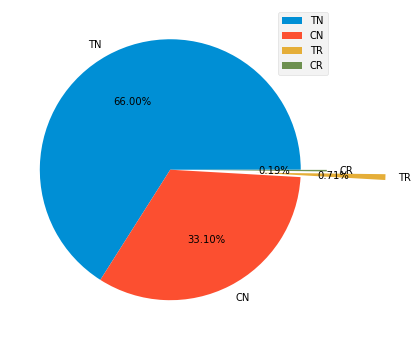

In [12]:
plt.rcParams['font.size'] = 10.0
plt.pie(pie, 
        autopct='%.2f%%', 
        labels=('TN','CN','TR','CR'),
        pctdistance=0.6,
        explode=(0,0,0.65,0.2),
        radius=1)
plt.legend()
plt.show()

From this we can observe that 66.00% customers did not buy anything after they received E-mails, which are almost two times larger than the proportion of those customers(CN) who did not receive any e-mail. In the meanwhile, 7.1% customers in treatment group and 1.9% in control group purchased merchandise.

**Histogram**

In the aim to see the distributions of all features, we create histograms.

<Figure size 1440x720 with 0 Axes>

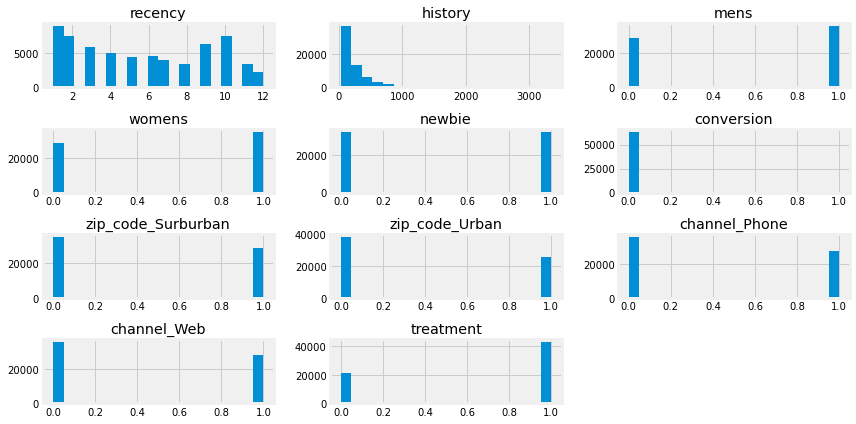

In [13]:
plt.figure(figsize=(20,10))  # enlarge the figure

# We create one histogram for each numeric variable and illustrate how to set the number of bins
df.hist(bins=20);
plt.tight_layout()

The feature `recency` has two peaks, one is near 0, the other one is in 10. This means that the new costumers(`recency` $\in$ [0,2]) form the largest group among all other groups, followed by the group of customers who have not bought anything for 10 months. 

The histogram of `history` is reasonable: less customers have high spending.

From `newbie` it is shown that there are about 50% new costumers in the dataset. 

`zip_code_Surburban` and `zip_code_Urban` express two opposite areas, so we assume that it will have negative correlation with each other which is supported by the heat map shown below.

**Heat map**

The aim of making a heat map is to check the correlation among these variables. 

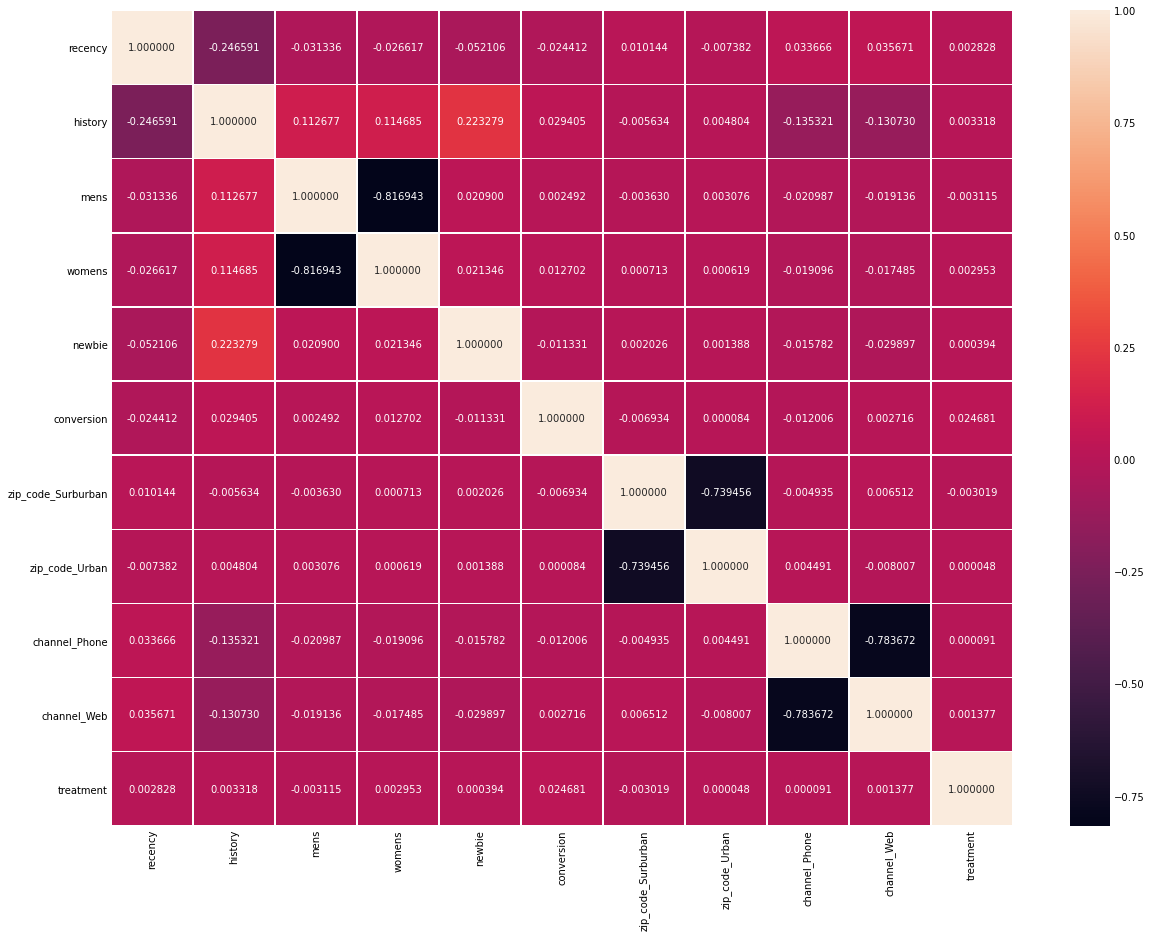

In [14]:
corr= df.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');

`mens` and `womens` are negative correlated, indicating that those who purchased Mens merchandise in the past year and those who bought Womens merchandise in the past year are generally two seperate groups.

It is also easy to understand why the other two groups of variables `zip_code_Surburban` and `zip_code_Urban`, `channel_Phone` and `channel_Web` are also strongly negative correlated, because they are mutually exclusive.

**Data Organization** 

We need to do data processing before we apply our models to them. We transform them into datatype float, to speed up modeling and to save more space. For easier handling, we separate them into feature matrix `X`, response `Y` and treatment `T`. Moreover, we split them into training set(80%) and test set(20%). 

In [15]:
# Save the space and speed up modeling
df['recency'] = df['recency'].astype('float64')
df['mens'] = df['mens'].astype('float64')
df['womens'] = df['womens'].astype('float64')
df['newbie'] = df['newbie'].astype('float64') 
df['conversion'] = df['conversion'].astype('float64')
df['zip_code_Surburban'] = df['zip_code_Surburban'].astype('float64')
df['zip_code_Urban'] = df['zip_code_Urban'].astype('float64')
df['channel_Phone'] = df['channel_Phone'].astype('float64')
df['channel_Web'] = df['channel_Web'].astype('float64')
df['treatment'] = df['treatment'].astype('float64')

# Extract target variable and feature matrix 
X = df.drop(['conversion','segment','treatment','response'], axis=1)
Y = df[['conversion']]
T = df[['treatment']]

# Creating training and test dataset
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42) # copy from causal net
### replace name
print(X_train.shape, X_test.shape, T_train.shape, T_test.shape, Y_train.shape, Y_test.shape)

(51200, 9) (12800, 9) (51200, 1) (12800, 1) (51200, 1) (12800, 1)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recency             64000 non-null  float64
 1   history             64000 non-null  float64
 2   mens                64000 non-null  float64
 3   womens              64000 non-null  float64
 4   newbie              64000 non-null  float64
 5   segment             64000 non-null  object 
 6   conversion          64000 non-null  float64
 7   zip_code_Surburban  64000 non-null  float64
 8   zip_code_Urban      64000 non-null  float64
 9   channel_Phone       64000 non-null  float64
 10  channel_Web         64000 non-null  float64
 11  treatment           64000 non-null  float64
 12  response            64000 non-null  object 
dtypes: float64(11), object(2)
memory usage: 6.3+ MB


## Uplift Model Evaluation Metrics

In this section we briefly explain which metrics we use to evaluate the uplift models. 


In general the *Gini coefficient* measures the goodness-of-fit by utilizing gains chart  (Devriendt et al., 2018). It is computed by measuring the ratio of the area between the curve of the cumulative lift (accumulation of the responses divided by total amount of responses) and the diagonal line (which is the random targeting) (*Figure 2*). The Gini coefficient ranges from 0 (i.e. the model performance is not better than random targeting) to +1 (i.e. it represents a perfect model which separates customers clearly into positive and negative class) and to -1 (i.e. worst model performance, where non-purchase is ranked above all purchasers) (Radcliffe, 2007, as cited in Radcliffe and Surry, 2011).   

However, the Gini coefficient is not a suitable measurement in an uplift modeling setting, where we have both the treatment and control groups, since it is impossible to simultaneously target and not target one customer and thus, we cannot know how an individual would respond in both groups (Devriendt et al., 2018). Therefore, evaluating uplift models requires specific performances measures to cope with the causal inference problem. We use the Qini coefficient and Qini curve and the AUUC as our evaluation metrics.  

The *Qini coefficient* by Radcliffe and Qini curves generalize the Gini coefficient (Radcliffe 2007, as cited in Devriendt et al., 2018). The evaluation of uplift models lean on gain charts for uplift. Gain charts are built by sorting the main population from best to worst lift performance and partitioning it in segments. The Qini curve (cumulative incremental gains) represents the cumulative difference in response rate between the treatment and control group, where groups of observations instead of individual observations are compared to evaluate the performance. The Qini curve is ranked by the uplift model from high to low uplift. The x-axis represents the proportion of the population targeted and the y-axis the cumulative incremental gains (*Figure 2*). The Qini coefficient is the area between the Qini curve (i.e. the performance of the uplift model) and the diagonal line (i.e. the random targeting) (Radcliffe and Surry, 2011). Note that higher Qini values corresponds to better performance.

Another metric to evaluate the performance of uplift models is *Area Under the Uplift Curve (AUUC)* (Rzepakowski & Jaroszewicz, 2010). In comparison to the Qini coefficient measure, the AUUC does not consider the random incremental gains through random targeting (Devriendt et al., 2018). The AUUC calculates the area underneath the uplift curve. We can compare this value to the area under the optimal curve. AUUC measures the cumulative uplift along individuals sorted by the predicted ITE. Higher AUUC score indicates a good model (larger incremental gains).  

<br>
<div>
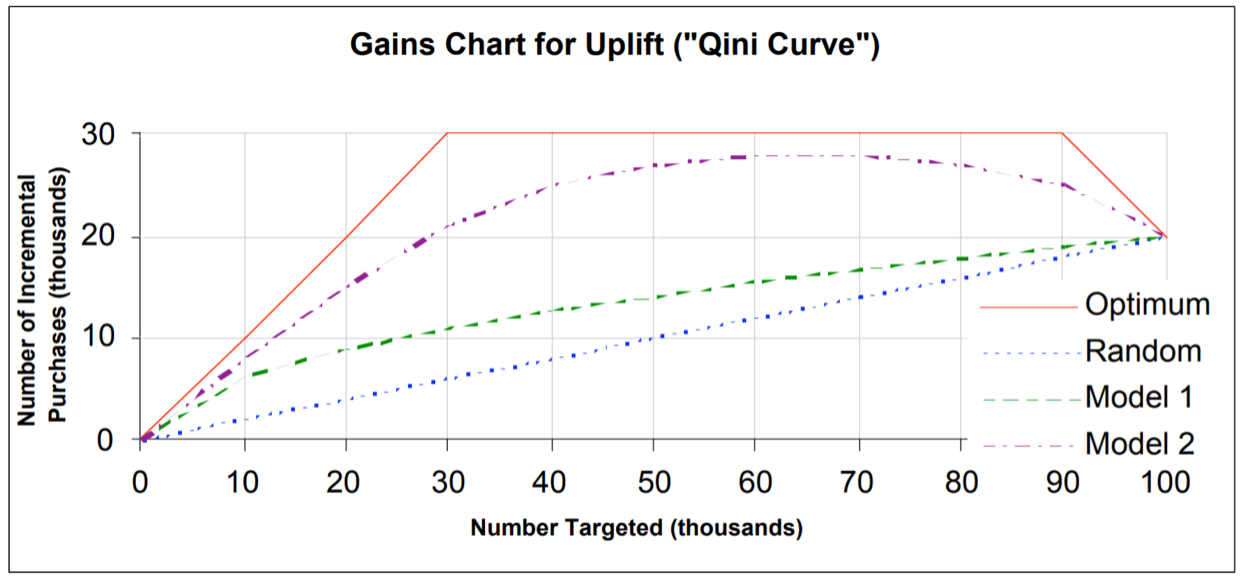
</div>


                                                       Figure 2: Gain Chart for Uplift-Curve (Radcliffe, 2007)

# Methodology

In this part, we would like to introduce theorem of our neural network methods and compare them. Firstly, we present the baseline model(T-learner). Then, we introduce the methods Causal Network and Dragonnet. Lastly, we present an additional method, called Causal Effect Variational Autoencoder (CEVAE).

## Baseline Model

**Theory of Baseline Model**


<br>
<div>
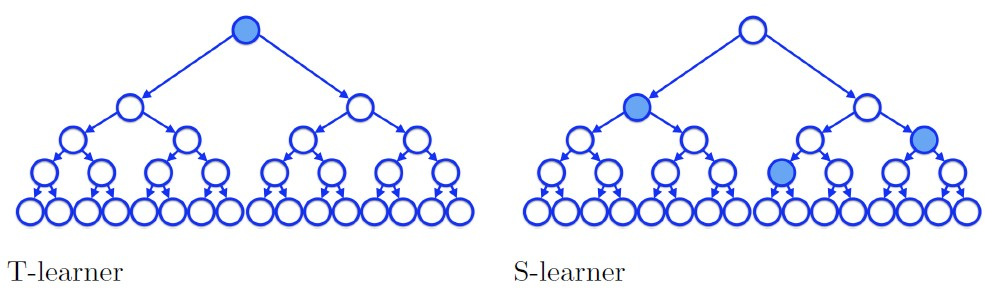
</div>

                                            Figure 3: The Architectures of T- & S-learner (Kuenzel et al., 2019)

We choose T-learner, a base-learner in meta-algorithms, as our benchmark model for estimating CATE. Previously, we also tried S-learner as a possilble bechmark model. However, its Qini curve result looks very similar to T-learner. Hence, we decided to discard S-learner. In the following we will briefly compare the theory between T- and S-learner. The difference between T- and S-learner is visually noticeable in *Figure 3*. 

According to Kuenzel et al.(2019), the T-learner includes two base learners which usually are linear regression methods or tree-based methods, in order to estimate seperately the conditional expectations of outcome from treatment and control groups. 

Step 1: Using any supervised machine learning or regression algorithm as a base learner to estimate $\mu_0(x)$ and $\mu_1(x)$:

$$\mu_0(x)=E[Y(0)|X=x]$$

$$\mu_1(x)=E[Y(1)|X=x]$$ 

With the treated observation, we can denote the estimators by $\hat{\mu_0}(x)$ and $\hat{\mu_1}(x)$.

Step 2: The T-learner is defined as:$$\hat{\tau_T}(x)=\hat{\mu_0}(x)-\hat{\mu_1}(x)$$

Its architecture is depicted in *Figure 3*. The blue circles are where the dataset would be splitted by treatment. Obviously, in T-learner, data is separated at the very beginning by treatment and then by its features. Then the CATE is gained from the different conditional expectations in the end of the model. 

Closely related to the T-learner, S-learner, a "single estimator", according to Kuenzel et al.(2019), estimates the outcome using all of the features and the treatment indicator, without giving the treatment indicator a special role. In other words, features and treatment indicator are ordered arbitrarily when estimating the outcome. That is why the split points of treatment(blue circles in *Figure 3*) possibly appear anywhere. 

**Implementation of Baseline Model**

There exists a python package called `causalml` (Lee et al., 2021) that contains many different packages for uplift modeling and causal inference methods with machine learning algorithms based on recent research. In this package, `XGBRegressor` is used for estimating `T-learner`. So we get the average treatment effect of Base learner, whose result is shown below.

In [17]:
# T-learner
learner_t = BaseTRegressor(learner=XGBRegressor(learning_rate = 0.0004))
learner_t.fit(X=X_train.values, treatment=np.ravel(T_train.values), y=np.ravel(Y_train.values))
cate_t = learner_t.predict(X=X_test.values, treatment=np.ravel(T_test.values), y=np.ravel(Y_test.values)).flatten()
print(cate_t)

[0.00017199 0.00017199 0.00017199 ... 0.00017199 0.00017199 0.00017199]


## Causal Network Algorithm

**Theory of Causal Network**

Causal Net is used as an abbreviation for Causal Network. Neural networks model the relationships between inputs and outputs via different patterns of hidden layers, the computational units in the hidden layers are called neurons. Farrell et al.(2018) use ReLU as activation function $\sigma(x) = max(x,0)$ to construct a feedforward neural network. 

<br>
<div>
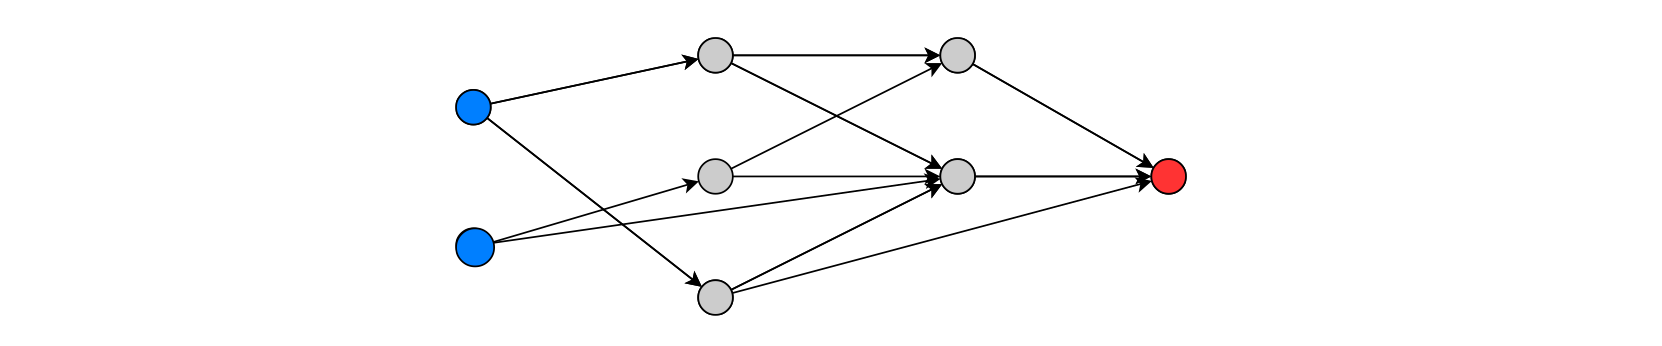
</div>

                                          Figure 4: Prototype of Causal Network Algorithm (Farrell et al., 2018)

As the prototype shows (*Figure 4*), there are U=5 hidden neurons, grouped in a sequence of L=2 layers, which is named the depth of the network. W=18 is denoted as the total number of parameters, with weights=12 and bias=6.

In the paper, they use the ATE as their parameter of interest. Empirically, the treatment is being mailed a catalog and the outcome is whether the person is converted. Because we train the model based on the inputs $X$, in reality the average realized outcome could be interpreted as estimated ATE.

The estimates of the regression functions $\mu_t(x) = E[Y(t)|X=x], t \in {0,1}$ is used for calculation of CATE: $\tau(x) = \mu_1(x)-\mu_0(x)$. Then the optimization function could be fomulated as:

$$
\begin{pmatrix} 
\hat{\mu_0}(x)\\ 
\hat{\tau}(x) = \hat{\mu_1}(x)-\hat{\mu_0}(x) \\
\end{pmatrix} := \underset{\tilde{\mu_0},\tilde{\tau}}{\operatorname{argmin}}\sum^{n}_{i=1}\frac{1}{2}(y_i-\tilde{\mu_0}(x_i)-\tilde{\tau}(x_i)t_i)^2
$$

This formular comes directly from the original paper, where $y_i$ are targets (in our context is convertion), $x_i$ are features, $\mu_0(x_i)$ reflects original conversion (0 or 1), and $\tau(x) = \hat{\mu_1}(x_i)-\hat{\mu_0}(x_i)$ is the CATE of catalog e-mailing.

Accordingly, we could expect that our ATE should be between 0 and 1. For example, if one customer is originally not converted, then after the e-mails strategy, the conversion might be increased, but the conversion target should still be smaller or equal 1. If our target is `spend`, then the range of "lift" will not have such limitation.

The main difference between T-learner and Causal Net is that the former is based on a two-model approach, which means to separately develop treatment and control response models to estimate the probability of response; While the latter one is to estimate the response and non-response based on the same model, and to use their estimates to estimate the treatment effect (Kane, Lo, and Zheng, 2014).


**Implementation of Causal Network**

From the GitHub repository `causalml` (Lee et al., 2021), we hereby apply a function called `causal_net_estimate` to build a model for causal inference.

The results and their interpretations from the `causal_net_estimate` function is as following:

- `tau_pred` is the estimated conditional average treatment effect

- `mu0_pred` is the estimated target value given x in case of no treatment

- `prob_t_pred` is the estimated propensity score

- `psi_0` is the influence function for given x in case of no treatment

- `psi_1` is the influence function for given x in case of treatment

- `history_dict` is the dictionary that stores validation and training loss values for CoeffNet
    
- `history_ps_dict` is the dictionary that stores validation and training loss values for PropensityScoreNet. If estimate_ps is set to None, history_ps_dict is set to None as well.

If we equip the neural network with only one hidden layer with 60 neurons, and its dropout_rates is 0.5 as a manner of regularization preventing from overfitting. The learning rate is assigned to be 0.0003, the optimization algorithm we choose is "Adam". Adaptive Moment Estimation ("Adam") is one of the gradient descent optimization algorithms that computes adaptive learning rates for each parameter, keeping an exponentially decaying average of past gradients (Ruder, 2016). Because our data is sparse, it is reasonable to use "Adam". The sensitivity analysis afterwards shows that learning rate is not sensitive after a specific threshold, which might be caused by this adaptive learning-rate method, "Adam".

In [18]:
# Getting causal estimates
tau_pred, mu0_pred, prob_t_pred, psi_0, psi_1, history, history_ps = causal_net_estimate(
    [X_train, T_train, Y_train], [X_train, T_train, Y_train], [X_test, T_test, Y_test],
    hidden_layer_sizes=[60], dropout_rates=[0.5], batch_size=None, alpha=0.,
    r_par=0., optimizer='Adam', learning_rate=0.0003,
    max_epochs_without_change=30, max_nepochs=10000, seed=123, estimate_ps=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 60)           600         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 60)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            122         dropout[0][0]                    
______________________________________________________________________________________________

## Dragonnet

**Theory of the Dragonnet**

Shi, Blei and Veitch (2019a) introduce a neural network architecture, the Dragonnet, to estimate the treatment effects for observational data. The Dragonnet is a three-headed neural network architecture that provides an end-to-end training to predict the conditional outcomes and the propensity score (*Figure 5*). The objective of the Dragonnet is to learn a shared representation layer $Z(X)$ that aims for good prediction of the conditional outcomes, and also for good prediction of the propensity score. The Dragonnet outputs two heads for the conditional outcomes $Q(t,x)$, denoted as $Q(1,X)$ if $t$=1 and $Q(0,X)$ if $t$=0 (input treatment $t$ and covariates $X$ to predict the outcome). Additionally, there is one head for the propensity score $g(x)$, which is used to enforce a representation that provides good treatment prediction.

<br>
<div>
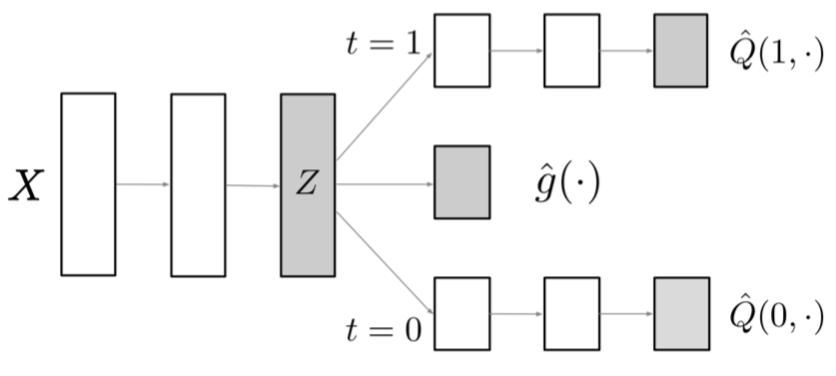
</div>

                                                  Figure 5: Dragonnet architecture (Shi, Blei and Veitch, 2019a)

The Dragonnet exploits the *sufficiency of the propensity score $g(x)$* (Shi, Blei and Veitch, 2019a). This is defined as: If the average treatment effect $\tau$ is identifiable from observational data by adjusting for $X$, then it is sufficient to adjust just for the propensitiy score.  

$$\tau = E[E[Y|g(X),t=1]-E[Y|g(X),t=0]]$$
if $$\tau = E[E[Y|X,t=1]-E[Y|X,t=0]]$$

So when working with observational data, it is sufficient to adjust only for the information in those features $X$ that are relevant to predict the treatment assignment $t$, and focus less on the other features that are relevant only for predicting the outcome $Y$. One way to efficiently filter the relevant features $X$ in the Dragonnet is to correct for the shared hidden layers (i.e. for example to produce a representation layer $Z(X)$ and by adding the propensity score as an additional output to discard the irrelevant information and instead focus only on the relevant information in $X$). If the propensity score head is removed from the Dragonnet, then the architecture is essentially the TARnet architecture from Shalit et al. (2016).    

Shi, Blei and Veitch (2019a) approach has two stages: At first they fit the model for the conditional outcome $Q(x)$ and the propensity score $g(x)$. In the next stage they plug these fitted models $Q(x)$ and $g(x)$ into a downstream estimator $\tau$.  

The authors use the *estimated average treatment effect with conditional outcome $\hat{\tau}^{Q}$*:
$$\hat{\tau}^{Q} = \frac{1}{n} \sum_i[\hat{Q}(1,x_i)-\hat{Q}(0,x_i)],$$where $\hat{Q}$ is the estimates of the conditional outcome $Q(t,x) = E[ Y | t, x ]$. This estimator is extended by considering $\hat{g}$ the estimates of the propensity score $g(x) = P( t=1| x)$.  

To train the model the authors define the *objective function* as a minimization problem: 

\begin{equation}
\hat{\theta} = argmin_{\theta} \hat{R}(\theta;X), where \\  
\hat{\mathbf{R}}(\theta;X) = \frac{1}{n} \sum_i [(Q^{nn}(t_i,x_i;\theta)-y_i)^2 + \alpha CrossEntropy(g^{nn}(x_i;\theta),t_i)] 
\end{equation} 

and $\theta$ denotes some parameters of the Dragonnet, $\hat{Q}^{nn}(t_i, x_i; \theta)$ and $\hat{g}^{nn}(x_i; \theta)$ are the output heads and $\alpha \in \mathbb{R}_+$ is a hyperparameter weighting the loss components of the loss function. Based on the fitted outcome model $\hat{Q}$, the treatment effect with the estimator $\hat{\tau}^Q$ can be estimated (Shi, Blei and Veitch, 2019a).  
Alternatively, the modified objective function, the *targeted regularization*, can be used for training the neural network (Shi, Blei and Veitch, 2019a). The targeted regularization is based on the non-parametric estimation theory. With this a fitted model with asymptotic properties can be guaranteed if $\hat{Q}$ and $\hat{g}$ are consistent estimators for the conditional outcome and propensity score and if the tuples satisfies the non-parametric estimating equation:  
\begin{equation}
0 = \beta \frac{1}{n} \sum \phi (y_i,t_i,x_i,\hat{Q},\hat{g},\hat{\tau}) 
\end{equation}
The neural network is then trained by minimizing this modified objective function (targeted regularization):  
\begin{equation}
\hat{\theta}, \hat{\epsilon} = argmin_{\theta,\epsilon}[\hat{R}(\theta;X) + \beta \frac{1}{n} \sum_i \gamma(y_i,t_i,x_i ; \theta, \epsilon)]
\end{equation}
where $\beta \in \mathbb{R}_+$ is a hyperparameter , $\epsilon$ a model parameter and $\gamma$ a regularization term.   
For this the estimator $\hat{\tau}^{treg}$ is defined as: 
\begin{equation}
\hat{\tau}^{treg}=\frac{1}{n}\sum_i \hat{Q}^{treg}(1,x_i)-\hat{Q}^{treg}(0,x_i) , where \\ 
\hat{Q}^{treg}=\tilde{Q}(\cdot;\cdot;\hat{\theta};\hat{\epsilon}) 
\end{equation}
Minimizing the targeted regularization term forces ($\hat{Q}^{treg}$, $\hat{g}$, $\hat{\tau}^{treg}$) to satisfy the non-parametric estimating equation.

**Implementation of the Dragonnet**

The `causalml`(Lee et al., 2021) python package also includes the neural network based algorithms of the relatively new model the Dragonnet, where we use the function `DragonNet` for the implementation procedure. Additionally, Shi, Blei and Veitch (2019b) provide a GitHub Repository with their implementation of the Dragonnet on semi-synthetic data for adapting neural networks for the estimation of treatment effects.  

We train the Dragonnet over 30 epochs following mostly the default configuration proposed by Shi, Blei and Veitch (2019b). However, we adjust some hyperparameters: the neurons per layer, the ratio and the learning rate. The default setting uses three fully connected layers with 200 units for the shared representation network, we use 190 units. The ratio is set to 0.7 and the learning rate to 0.0006. We apply the default modified objective function, the targeted regularization, as it should improve the estimation further according to the authors findings. We also use the default of a combined loss function (the so-called dragonnet_loss_binarycross, i.e. the regression loss and binary classification loss) and the L2 regularization (Ridge Regression) to prevent overfitting. The propensity score function $g(x)$ is implemented as a single linear layer with sigmoid activation function, which forces the representation layer to tightly couple to the estimated propensity score (Shi, Blei and Veitch, 2019a).   

After doing the sensitive analysis (view details in section 5.3) we are able to achieve better performance. Without the sensitive analysis the Dragonnet performs slightly worse than the random targeting. We assume this might be due to the finding of Shi, Blei and Veitch (2019a) that the Dragonnet's improvements is more significant with smaller data size. Also, the Dragonnet is supposed to predict the outcome from only information relevant to treatment $t$, and thus, it has worse performance as a predictor for the outcome, but better performance as an estimator (Shi, Blei and Veitch, 2019a).  

Here is an overview of the parameters with the default values of the `DragonNet` function: 
- neurons_per_layer=200  
- targeted_reg=True (targeted regularization)
- ratio=1.0  
- val_split=0.2  
- batch_size=64  
- epochs=30  
- learning_rate=0.001
- reg_l2=0.01 : L2 Loss Function (Ridge Regression) to minimize the error which is the sum of the all the squared differences between the true value and the predicted value.
- loss_func: dragonnet_loss_binarycross is a combination of the regression loss and binary classification loss (binary_crossentropy) of the predicted values
- verbose=True

In [19]:
## Train the neural network: Dragonnet Model
# Take a little longer time compared to Causal net

dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)

## Fit the model
dragon.fit(X_train, T_train, Y_train)

## Predict ITE
dragon_ite = dragon.predict(X_test, T_test, Y_test)
#dragon_ate = dragon_ite.mean()    

Epoch 1/30
640/640 [==============================] - 5s 5ms/step - loss: 127.8742 - regression_loss: 34.9032 - binary_classification_loss: 48.5696 - treatment_accuracy: 0.6416 - track_epsilon: 0.0289 - val_loss: 50.2482 - val_regression_loss: 1.0606 - val_binary_classification_loss: 43.3023 - val_treatment_accuracy: 0.5950 - val_track_epsilon: 0.0221
Epoch 2/30
640/640 [==============================] - 3s 5ms/step - loss: 47.3074 - regression_loss: 0.7483 - binary_classification_loss: 41.4039 - treatment_accuracy: 0.6619 - track_epsilon: 0.0200 - val_loss: 46.5308 - val_regression_loss: 0.6824 - val_binary_classification_loss: 41.0557 - val_treatment_accuracy: 0.6646 - val_track_epsilon: 0.0142
Epoch 3/30
640/640 [==============================] - 3s 5ms/step - loss: 46.6950 - regression_loss: 0.7048 - binary_classification_loss: 41.2054 - treatment_accuracy: 0.6643 - track_epsilon: 0.0123 - val_loss: 45.9560 - val_regression_loss: 0.6776 - val_binary_classification_loss: 40.7636 - v

Epoch 5/300
640/640 [==============================] - 2s 3ms/step - loss: 41.7113 - regression_loss: 0.5144 - binary_classification_loss: 40.5809 - treatment_accuracy: 0.6707 - track_epsilon: 6.0035e-04 - val_loss: 42.0134 - val_regression_loss: 0.5942 - val_binary_classification_loss: 40.7239 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 7.1840e-04
Epoch 6/300
640/640 [==============================] - 3s 4ms/step - loss: 42.0081 - regression_loss: 0.5741 - binary_classification_loss: 40.7585 - treatment_accuracy: 0.6670 - track_epsilon: 5.4959e-04 - val_loss: 41.9747 - val_regression_loss: 0.5942 - val_binary_classification_loss: 40.6853 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 2.4098e-04
Epoch 7/300
640/640 [==============================] - 3s 4ms/step - loss: 41.8306 - regression_loss: 0.5382 - binary_classification_loss: 40.6531 - treatment_accuracy: 0.6696 - track_epsilon: 3.7835e-04 - val_loss: 41.9892 - val_regression_loss: 0.5947 - val_binary_classificat

Epoch 27/300
640/640 [==============================] - 2s 3ms/step - loss: 42.0199 - regression_loss: 0.5363 - binary_classification_loss: 40.8490 - treatment_accuracy: 0.6642 - track_epsilon: 3.2025e-04 - val_loss: 41.9708 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6843 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 8.4344e-05
Epoch 28/300
640/640 [==============================] - 2s 3ms/step - loss: 41.8725 - regression_loss: 0.5208 - binary_classification_loss: 40.7326 - treatment_accuracy: 0.6669 - track_epsilon: 8.2444e-05 - val_loss: 41.9652 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6785 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 2.5831e-04
Epoch 29/300
640/640 [==============================] - 2s 3ms/step - loss: 42.1095 - regression_loss: 0.5793 - binary_classification_loss: 40.8527 - treatment_accuracy: 0.6640 - track_epsilon: 1.7511e-04 - val_loss: 41.9862 - val_regression_loss: 0.5941 - val_binary_classifi

640/640 [==============================] - 2s 4ms/step - loss: 42.0943 - regression_loss: 0.5649 - binary_classification_loss: 40.8665 - treatment_accuracy: 0.6637 - track_epsilon: 5.9459e-05 - val_loss: 41.9617 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6756 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 1.3737e-04
Epoch 50/300
640/640 [==============================] - 2s 4ms/step - loss: 41.9524 - regression_loss: 0.5708 - binary_classification_loss: 40.7128 - treatment_accuracy: 0.6672 - track_epsilon: 8.5370e-05 - val_loss: 41.9617 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6756 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 1.2270e-04

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.
Epoch 51/300
640/640 [==============================] - 2s 3ms/step - loss: 41.9800 - regression_loss: 0.5459 - binary_classification_loss: 40.7903 - treatment_accuracy: 0.6654 - track_epsilon: 1.1584e-04 - va

640/640 [==============================] - 2s 3ms/step - loss: 41.7407 - regression_loss: 0.5490 - binary_classification_loss: 40.5448 - treatment_accuracy: 0.6709 - track_epsilon: 8.5056e-06 - val_loss: 41.9617 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6757 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 7.7787e-06
Epoch 72/300
640/640 [==============================] - 2s 3ms/step - loss: 41.9341 - regression_loss: 0.5408 - binary_classification_loss: 40.7546 - treatment_accuracy: 0.6662 - track_epsilon: 9.5443e-06 - val_loss: 41.9618 - val_regression_loss: 0.5941 - val_binary_classification_loss: 40.6757 - val_treatment_accuracy: 0.6681 - val_track_epsilon: 7.5592e-06
Epoch 73/300
640/640 [==============================] - 2s 3ms/step - loss: 41.9225 - regression_loss: 0.5243 - binary_classification_loss: 40.7760 - treatment_accuracy: 0.6657 - track_epsilon: 1.3402e-05 - val_loss: 41.9617 - val_regression_loss: 0.5941 - val_binary_classification_loss: 

## CEVAE

The Dragonnet as well as the CEVAE are based on the TARnet architecture by Shalit et al. (2016). TARnet is a feed forward neural network architecture for causal inference (Shalit et al., 2016). While the Dragonnet extends the TARnet with it’s additional output head for the propensity score, the CEVAE conditions on latent variable instead on observations as in TARnet.  In this section we introduce the architecture of CEVAE by Louizos et al. (2017) and our implementation procedure. 

**Theory of CEVAE**

Louizos et al.(2017) propose a new model for estimating ITE, which is based on Variational Autoencoders following the causal structure of inference with proxies. *Figure 6* shows a simplified architecture of CEVAE, which is extracted from the paper of Louizos et al.(2017).


<br>
<div>
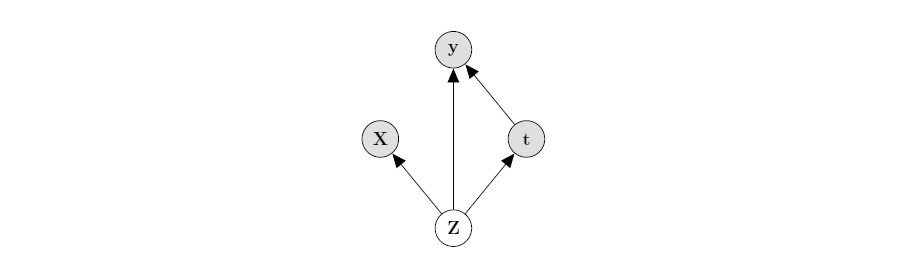
</div>
                                                                       
                                                       Figure 6: Prototype from CEVAE (Louizos et al., 2017)
                                                                       
`t` is a treatment, `y` is an outcome, `Z` is an unobserved confounder and `X` is feature variables which has noisy views on `Z`.

As this prototype shows, Louizos et al.(2017) assume that there is a latent variable $Z$, which is an unobserved confounder and has an effect on the outcome $y$. Furthermore, they assume that the joint distribution $p(Z;X;t;y)$ of the latent confounder $Z$ and the observed confounders $X$ can be approximately recovered from the observations $(X; t; y)$ and $y$ is independent of $X$ given $Z$.

The goal of this paper is to recover the ITE:
$$ITE(x) := E[y|X = x; do(t = 1)] - E[y|X = x; do(t = 0)]$$
$$ATE := E[ITE(x)]$$

`do` means using do-calculus rules.

They prove that if $p (Z;X; t; y)$ can be recovered then the ITE under the causal model in *Figure 7* would also be recovered. With the theorem, they obtain $$p(y|X; do(t = 1)) = \int_{Z} p(y|t = 1;Z)\; p(Z|X) dZ$$.

<br>
<div>
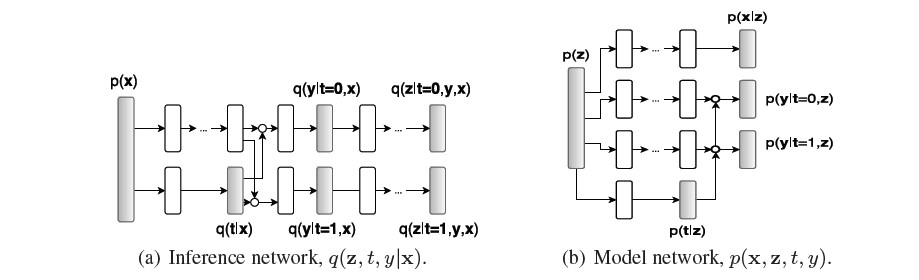
</div>

                                                          Figure 7: Architecture of CEVAE (Louizos et al., 2017)
                                             
In *Figure 7*, white nodes mean parametrized neural network transformation, grey nodes mean drawing samples from their distribution and white circles mean switching paths according to the treatment.

This is the architecture of CEVAE, which includes two networks, model network(Figure 7, b) and inference network(Figure 7, a). In model networks, ITE and the distribution over $Z$ could be recovered. In inference network, samples could be predicted by inferring the distribution over $Z$. While the model network is for training, the inference network is for predicting.

So firstly, they set $p(z_i)\, =\, \prod_{j=1}^{D_z} N(z_{ij}|0,1)$, so that they can calculate the conditional probability $p(x_i|z_i)$ and $p(t_i|z_i)$. It should be mentioned that for a discrete outcome, they use Bernoulli distribution similarly parametrized by a TARnet and Gaussian distribution for a continuous outcome. Thus, $p(y_i|t_i;z_i) = N(\mu, \sigma^2)$ or $p(y_i|t_i;z_i) =  Bern(\pi)$ would be estimated from neural networks. 

So far, the model network has been trained. But how to predict results? In fact, they use the true posterior over $Z$ depends on $X$, $t$ and $y$, in order to employ the following posterior approximation:
$$q(z_i|x_i; t_i; y_i) =\prod_{j=1}^{D_z} N(\mu_j = \bar{\mu}_{ij} ; \sigma^2_j = \bar{\sigma}^2_{ij})$$

Same as before, parameters $\sigma$ and $\mu$ will be estimated from neural network. They get the treatment assignment $t$ from its outcome $y$ before inferring the distribution over $Z$ from distributions $q(t_i|x_i)$ and $q(y_i|t_i;z_i)$, whose parameters would be trained by networks, too. 

In this algorithm, they also mention the variational lower bound, which is used for optimizing the inference network:

$$\mathscr{L}=\sum^{N}_{i=1} \mathbb{E}_{q(z_i|x_i;t_i;y_i)}[log p(x_i,t_i|z_i) + log p(y_i|t_i,z_i)+log p(z_i)-log q(z_i|x_i;t_i;y_i)]$$

$$\mathscr{F}_{CEVAE}=\mathscr{L}+\sum^{N}_{i=1}logq(t_i=t^*_i|x^*_i)+log q(y_i=y^*_i|x^*_i,t^*_i)$$

$t^*_i$,$x^*_i$ and $y^*_i$ is the observed value in model network. However, because of its difficult calculation and limits, we would not use it in other approaches.

**Implementation of CEVAE**

The `causalml`(Lee et al., 2021) python package also includes the `CEVAE` which we install for our implementation. So here we directly input `CEVAE` function from package `causalml`. 

We need to prepare the dataframe first since the concept of `CEVAE` requires to reorder the columns of dataframe depending on the data type due to the different distribution that they are assigned to, i.e. binary variables with Gausian distribution and continous variables with Bernoulli distribution.  

In [20]:
## Reorder the columns of df by binary (Gausian distribution) and continous (Bernoulli distribution) variables 
# Reorder features with binary first and continuous after

df_cevae = df[["mens","womens","newbie","segment","conversion","zip_code_Surburban","zip_code_Urban","channel_Phone","channel_Web","treatment","recency","history"]]
df_cevae

,mens,womens,newbie,segment,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,treatment,recency,history
0,1.0,0.0,0.0,Womens E-Mail,0.0,1.0,0.0,1.0,0.0,1.0,10.0,142.44
1,1.0,1.0,1.0,No E-Mail,0.0,0.0,0.0,0.0,1.0,0.0,6.0,329.08
2,0.0,1.0,1.0,Womens E-Mail,0.0,1.0,0.0,0.0,1.0,1.0,7.0,180.65
3,1.0,0.0,1.0,Mens E-Mail,0.0,0.0,0.0,0.0,1.0,1.0,9.0,675.83
4,1.0,0.0,0.0,Womens E-Mail,0.0,0.0,1.0,0.0,1.0,1.0,2.0,45.34
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,1.0,0.0,0.0,Mens E-Mail,0.0,0.0,1.0,0.0,1.0,1.0,10.0,105.54
63996,0.0,1.0,1.0,Mens E-Mail,0.0,0.0,1.0,1.0,0.0,1.0,5.0,38.91
63997,1.0,0.0,1.0,Mens E-Mail,0.0,0.0,1.0,1.0,0.0,1.0,6.0,29.99
63998,1.0,0.0,1.0,Womens E-Mail,0.0,1.0,0.0,0.0,0.0,1.0,1.0,552.94


In [21]:
## Extract target variable and features 
X = df_cevae.drop(['conversion','segment','treatment'], axis=1)
Y = df_cevae[['conversion']]
T = df_cevae[['treatment']]

In [22]:
## Transform columns (X, Y, T) into array 
T_array = T.loc[:,'treatment'].values
T_array

Y_array = Y.loc[:,'conversion'].values
Y_array

X_array = X.loc[:,["mens","womens","newbie","zip_code_Surburban","zip_code_Urban","channel_Phone","channel_Web","recency","history"]].values
X_array


## Create training and test dataset
itr, ite = train_test_split(np.arange(X_array.shape[0]), test_size=0.2, random_state=1)
X_train_c, T_train_c, Y_train_c = X_array[itr], T_array[itr], Y_array[itr]
X_test_c, T_test_c, Y_test_c = X_array[ite], T_array[ite], Y_array[ite]
print(X_train_c.shape, X_test_c.shape, T_train_c.shape, T_test_c.shape, Y_train_c.shape, Y_test_c.shape)

(51200, 9) (12800, 9) (51200,) (12800,) (51200,) (12800,)


In the following we use the function `CEVAE` for this algorithm. Here are parameters in `CEVAE`.

- `outcome_dist`is the distribution as one of: "bernoulli" , "exponential", "laplace", "normal" and "studentt".
- `latent_dim`is dimension of the latent variable.
- `hidden_dim`is dimension of hidden layers of fully connected networks.
- `num_epochs`is number of training epochs.
- `num_layers`is number of hidden layers in fully connected networks
- `batch_size`is batch size
- `learning_rate`is the final learning rate, which would be learning_rate * learning_rate_decay
- `learning_rate_decay`is learning rate decay over all epochs

It should be mentioned that setting of `latent_dim`, `hidden_dim`, `num_layers` and two `learning rate` come from Louizos et.al.(2017). Because they got them from another papers and thought that would be the most proper setting, so we did not change them. Besides, we did not do tuning for `CEVAE`, the reason is that has taken more than 1.5 hours. If we tune it, it must cost too much time. So we use the default setting for unmentioned parameters, `num_epochs`, `num_layers` and `batch_size`.

In [23]:
## Apply CEVAE MODEL - DEFAULT settings

'''cevae = CEVAE(outcome_dist="bernoulli", #not default     ##Outcome distribution: "bernoulli" , "exponential", "laplace", "normal", "studentt"
              latent_dim=20,                          ##Dimension of latent variable
              hidden_dim=200,                         ##Dimension of hidden layers of fully connected networks
              num_epochs=50,                         ##Number of training epochs
              batch_size=100,                        ##Batch size
              learning_rate=0.001,                    ##the final learning rate will be learning_rate * learning_rate_decay
              learning_rate_decay=0.01, 
              num_layers=3) #not 2                    ##Number of hidden layers in fully connected networks

## fit 
losses = cevae.fit(X=torch.tensor(X_train_c, dtype=torch.float),
                   treatment=torch.tensor(T_train_c, dtype=torch.float),
                   y=torch.tensor(Y_train_c, dtype=torch.float))

## predict
cevae_ite = cevae.predict(X_test_c, T_test_c, Y_test_c)'''

# Because it took one hour to get the result, we store the data from prediction and import it directly

# Read the result
data_url1 = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/cevae_loss.csv'
data_url2 = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/cevae_ite.csv'

losses = pd.read_csv(data_url1)
cevae_ite = pd.read_csv(data_url2)

In [24]:
cevae_ite1 = cevae_ite['cevae_ite']

# Tune Parameters

In this section we show the process on how we tune the hyperparameters of our models and show its results.  

Since we do not know the suitable architecture for all methodologies, and there is a risk to directly use the default parameters provided by the focal paper of each model, we decide to tune the model empirically. Unfortunately, both `GridSearchCV` and `BayesianOptimization` do not meet the need of our models, we have to do some sensitivity analysis and then tune the parameters from scratch.

Rerunning the tuning part is sort of waste of time, because it took quite a long time. we are determined to store the results and present them straightforward. The detailed codes are stored in the file `utils.py`, which needs to be stored in a local position. The link with the file to our global GitHub repository can be found here: https://github.com/Aubreyldy/APA_M1_data.

In [25]:
import sys
sys.path.append(".../utils.py")  #Change to a local path 
import utils

## Baseline Model Tuning

In [26]:
###### T-learner
Tlearner = pd.DataFrame(columns=['lr','ate','auuc','qini'])

# Time records
start_time = time.time()
# Meta-parameter of one-layer-nn

# index for store
s=1

for h in np.linspace(0.0002,0.001,num=5):
    Params = {'1': h}
    ate_1, auuc_1, qini_1= utils.cv_cn("T_learner",X_train, X_test,
                                 T_train, T_test, Y_train, Y_test,Params)
    Tlearner.loc[s, ['lr']] = h
    Tlearner.loc[s, ['ate']] = ate_1
    Tlearner.loc[s, ['auuc']] = auuc_1
    Tlearner.loc[s, ['qini']] = qini_1
    s=s+1
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.29833984375 seconds ---


In [27]:
Tlearner

,lr,ate,auuc,qini
1,0.0002,0.000101,0.677724,0.203848
2,0.0004,0.000201,0.677724,0.203848
3,0.0006,0.000299,0.677719,0.203841
4,0.0008,0.000395,0.677719,0.203841
5,0.001,0.000489,0.677719,0.203841


The AUUC and Qini of T-learner are all insensitive to the tuning. To ensure coherency, the learning rate is set to be 0.0004 above.

## Causal Network Tuning

Tuning parameters in Causal Net is way more complicated, because there are several options, and especially for hidden layer size and dropout rate, we can even adjust the number of layers. First we choose the two-layers architecture, observing the trend of results from tuning. The architecture is hidden layer size = [30,i], dropout rate = [0.5,0], i is in range of (10,41).

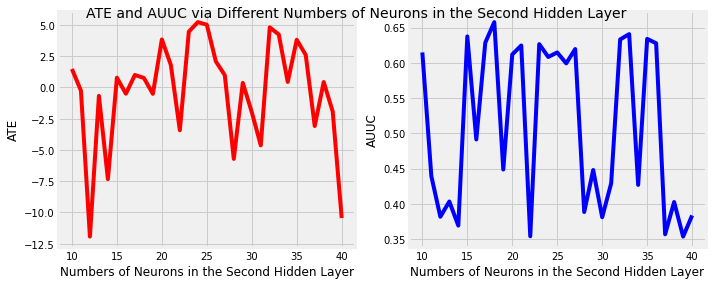

<module 'matplotlib.pyplot' from '/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [28]:
# Read the result
data_url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/ATE_AUUC_hls.csv'
ATE_AUUC_hls = pd.read_csv(data_url)
ATE_AUUC_hls = ATE_AUUC_hls.drop(ATE_AUUC_hls.columns[0], axis=1)

# Plot Function
utils.ourplot(range(10,41), ATE_AUUC_hls,ATE_AUUC_hls, y11='ATE_hls',y12='ATE_hls', y21='AUUC_hls',y22='AUUC_hls',
        x='Numbers of Neurons in the Second Hidden Layer',
        title='ATE and AUUC via Different Numbers of Neurons in the Second Hidden Layer',num=1)



In [29]:
# Select the Hidden Layer Size with Best AUUC
A = np.array(ATE_AUUC_hls.AUUC_hls==max(ATE_AUUC_hls.AUUC_hls))
print("The maximum of AUUC is: ", max(ATE_AUUC_hls.AUUC_hls))
print("The corresponding QINI is: ", ATE_AUUC_hls.QINI_hls[np.where(A)[0].item()])
print("The corresponding ATE is: ", ATE_AUUC_hls.ATE_hls[np.where(A)[0].item()])

The maximum of AUUC is:  0.6576993771916155
The corresponding QINI is:  0.1817695217130869
The corresponding ATE is:  0.7592846751213074


From the two line plot we can see that there are some weird ATEs which are beyond the range of 0 and 1. It might be because the ReLU activation function cannot bound the result into the reasonable range for binary output. But if we select the best AUUC in the experiment, the corresponding ATE is inside the range. In the paper, the reason why they change smooth sigmoid-type activation function to ReLU(rectified linear units) is to overcome optimization hurdles, and they argue that ReLU is for general feedforward achitecture, letting the bound be operational and flexible to yield an optimal rate, while optimizing a deep net with sigmoid-type activation is unstable.

Then we check the sensitivity of dropout rate.

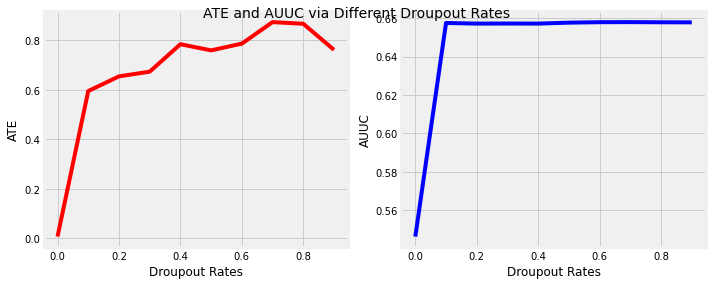

<module 'matplotlib.pyplot' from '/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [30]:
# Read the result
data_url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/ATE_AUUC_dr.csv'
ATE_AUUC_dr = pd.read_csv(data_url) 
ATE_AUUC_dr = ATE_AUUC_dr.drop(ATE_AUUC_dr.columns[0], axis=1)

utils.ourplot(np.linspace(0,0.9,num=10), ATE_AUUC_dr,ATE_AUUC_dr,y11='ATE_dr', y12='ATE_dr', y21='AUUC_dr',y22='AUUC_dr',
        x='Droupout Rates',
        title='ATE and AUUC via Different Droupout Rates',num=1)

In [31]:
# Select the Dropout Rate with Best AUC
A = np.array(ATE_AUUC_dr.AUUC_dr==max(ATE_AUUC_dr.AUUC_dr))
print("The maximum of AUUC is: ", max(ATE_AUUC_dr.AUUC_dr))
print("The corresponding QINI is: ", ATE_AUUC_dr.QINI_dr[np.where(A)[0].item()])
print("The corresponding ATE is: ", ATE_AUUC_dr.ATE_dr[np.where(A)[0].item()])

The maximum of AUUC is:  0.6579800992254909
The corresponding QINI is:  0.1820759845341336
The corresponding ATE is:  0.8734858632087708


Up to some points, the AUUC is not too sensitive to the increasing of dropout rate any more, compared to the beginning stage.

Next we try to delete one layer from that, keeping others the same. The result shows that only keeping the first layer would be more possible to give a better result. The architecture for one-layer causal neural net is hidden layer size = [30], dropout rate = [0.5].

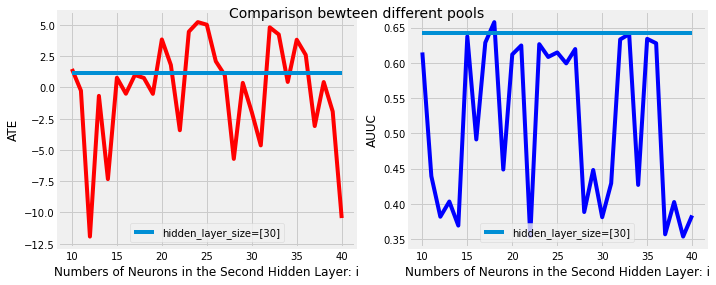

<module 'matplotlib.pyplot' from '/Users/aubrey/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [32]:
# Read the result
data_url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/ATE_AUUC_hln.csv'
ATE_AUUC_hln = pd.read_csv(data_url) 
ATE_AUUC_hln = ATE_AUUC_hln.drop(ATE_AUUC_hln.columns[0], axis=1)

utils.ourplot(range(10,41),ATE_AUUC_hls,ATE_AUUC_hln,y11='ATE_hls',y12='ATE_hln',y21='AUUC_hls',y22='AUUC_hln',
       x='Numbers of Neurons in the Second Hidden Layer: i',
       title='Comparison bewteen different pools',num=2,nn=31,lab='hidden_layer_size=[30]')

Finally, we tune the one-layer architecture comprehensively empirically.

<AxesSubplot:xlabel='dropout rate', ylabel='AUUC'>

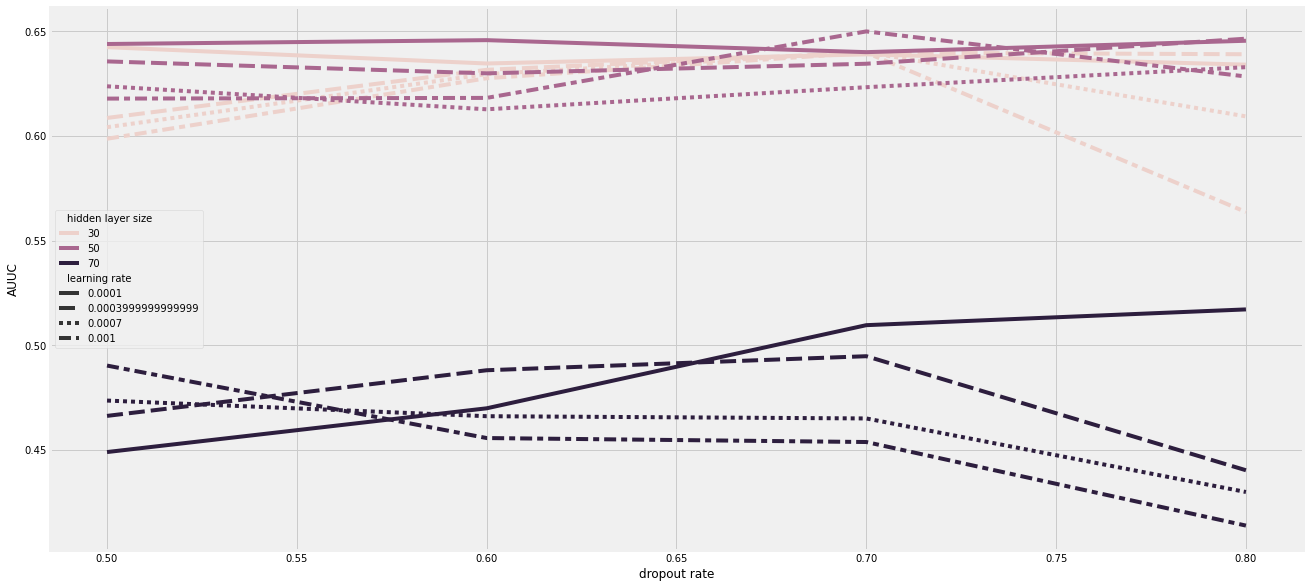

In [33]:
# Read the result
data_url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/ATE_AUUC_2.csv'
ATE_AUUC_2 = pd.read_csv(data_url) 
ATE_AUUC_2 = ATE_AUUC_2.drop(ATE_AUUC_2.columns[0], axis=1)

ATE_AUUC_2.columns = ['hidden layer size','dropout rate','learning rate','ATE','AUUC']

%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data=ATE_AUUC_2, x="dropout rate", y="AUUC", hue="hidden layer size", style="learning rate")

Based on this specific data and parameter setting, when hidden layer size is set to 30 or 50, the AUUC scores are higher than that whose hidden layer size is 70. Expect for this trend, it is difficult to say which learning rate and dropout rate is more suitable. Specific to the pools that we try, the combination of one-layer with 50 hidden layer size, 0.001 learning rate and 0.7 dropout rate is satisfying. This parameter setting has slightly lower AUUC than what we choose to implement Causal Net above, therefore, this session is only to show how the tuning could be accomplished.

In conclusion, before implementing directly the treatment estimation methods, it is reasonable to tune the parameter, in case the result is not optimal.

## Dragonnet Tuning

There are mainly three parameters that could be tuned: neurons per layer(npl), ratio and learning rate(lr), because these three parameters significantly affect the result.

<AxesSubplot:xlabel='r', ylabel='auuc'>

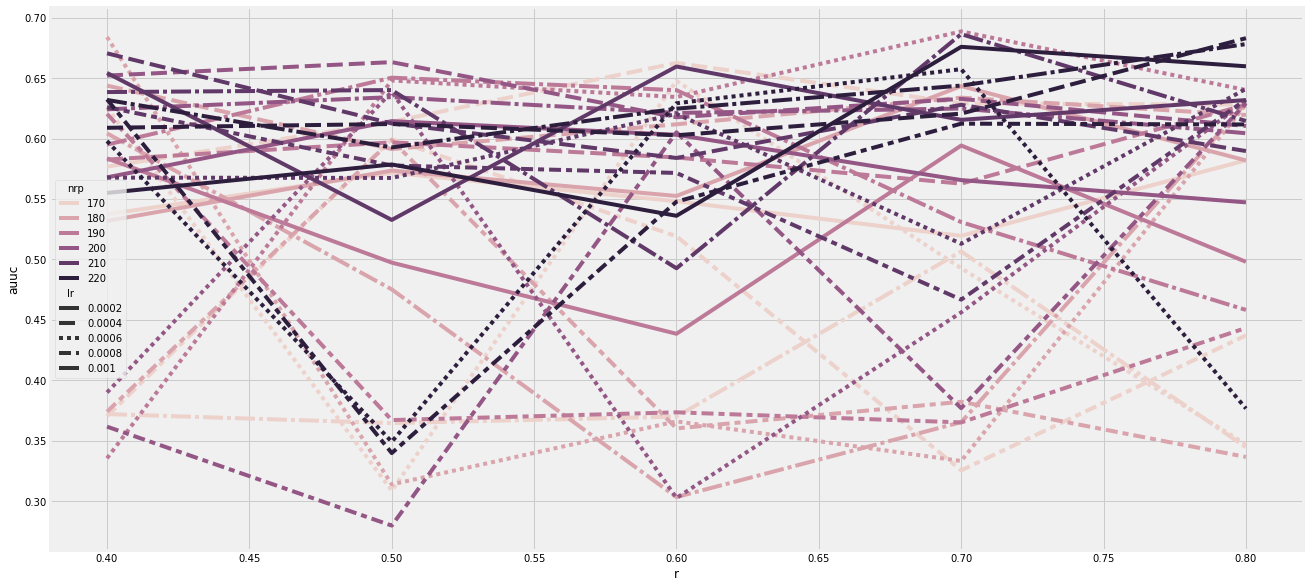

In [47]:
# Read the result
data_url = 'https://raw.githubusercontent.com/Aubreyldy/APA_M1_data/main/ATE_AUUC_dragon.csv'
dragon1 = pd.read_csv(data_url) 
dragon2 = dragon1.drop(dragon1.columns[0], axis=1)

# Plot
%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)
sns.lineplot(data=dragon2, x="r", y="auuc", hue="nrp", style="lr")

From the result above, Dragonnet is sensitive to tuning.

In [49]:
# The Best Pool from Above
dragon2[dragon2['auuc']==max(dragon2['auuc'])]

,nrp,r,lr,ate,auuc,qini
67,190,0.7,0.0006,0.005681,0.688661,0.214339


# Empirical Results

In this section, we plot the distribution of CATE as well as the Gain chart and compute the AUUC and Qini scores of our models based on the previous hyperparameters tuning setup. 

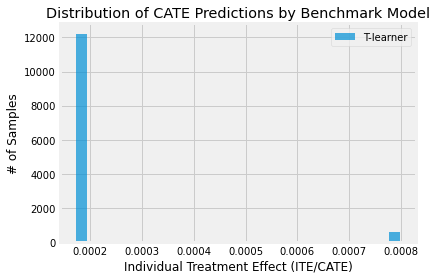

In [50]:
alpha=0.7
bins=30
plt.figure(figsize=(6,4))

plt.hist(cate_t, alpha=alpha, bins=bins, label='T-learner')
plt.title('Distribution of CATE Predictions by Benchmark Model')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()
plt.tight_layout()

The result of CATE distribution from baseline model is reasonable. The T-learner is Two-Tree estimator, thus its observation is shown in two groups. Obviously, we cannot use the results from baseline model, since they are too simple and just to provide reference results to compare it with our neural network models.

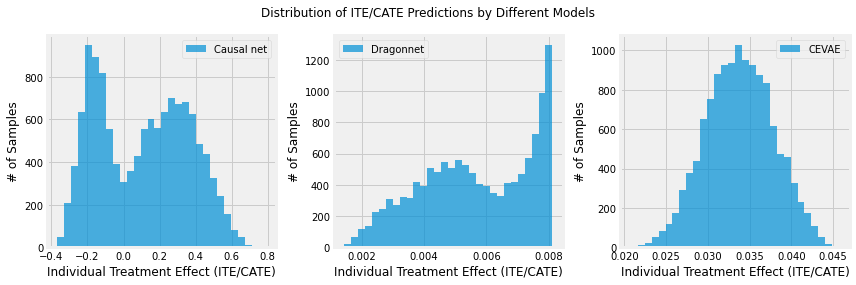

In [51]:
alpha=0.7
bins=30
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.hist(tau_pred, alpha=alpha, bins=bins, label='Causal net')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

plt.subplot(1, 3, 2)
plt.hist((dragon_ite[:,1]-dragon_ite[:,0]), bins=bins, alpha=alpha,  label='Dragonnet')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

plt.subplot(1, 3, 3)
plt.hist(cevae_ite1, bins=bins, alpha=alpha,  label='CEVAE')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

plt.suptitle('Distribution of ITE/CATE Predictions by Different Models')
plt.tight_layout()


The plots above represent the distribution of ITE/CATE over the sample size of a number of targeted customers. However, the range of ITE/CATE values varies between the different neural network models of the Causal Net, Dragonnet and CEVAE. Unfortunately, we cannot observe a clear tendency over all the applied neural network models of customers respond to our treatment from the first glance.

In the result from Causal Net, although the largest group in our potential customers has negative CATE, which means that they might be pushed away from purchasing due to our e-mailing treatment, the majority of people tend to increase the possibility to buy in our e-mail campaign. Therefore, if we were marketing decision-makers, we would only send e-mails to those customers who have positive CATE and stop distributing advertisement to those customers who have negative CATE. 

The result of the Dragonnet shows the distribution of the targeted customers over only a small range, close to the value zero. This indicates that the effect of our treatment variable, i.e. to treat customers with the e-mail campaign in order to gain a conversion, is not significant enough. However, we can observe a tendency leaning towards positive CATE, i.e. that customers are likely to buy due to our e-mail campaign. But from the perspective of a marketing decision-maker, we would probably need to increase the size of our samples to make a profound decision on whether it really pays off to target potential customers with the e-mail campaign. Also, we further assume its performance is due to the fact that the Dragonnet's improvements is more significant with smaller data size as it is also mentioned in the authors' findings.

Similar to the result of Dragonnet, the CATE of the CEVAE ranges close to the value zero. It also shows the trend that sending e-mails to potential customers has positive effect. However, the following gain plot shows that this result of the CEVAE is doubtable.

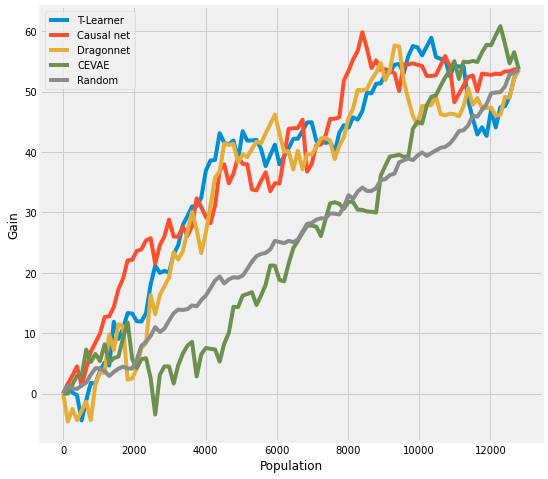

In [52]:
dft = pd.DataFrame({'y': np.ravel(Y_test), 'w': np.ravel(T_test),
                    'T-Learner': cate_t.flatten(),
                    'Causal net': tau_pred.flatten(),
                    'Dragonnet': (dragon_ite[:,1]-dragon_ite[:,0]).flatten(),
                   'CEVAE': cevae_ite1})
plot(dft, outcome_col='y', treatment_col='w')


The reason why the random line is curved is that the inbuilt function `plot` from `causalml` does not draw an artificial line with a constant slope, rather, it samples from a uniform distribution within the range of 0 and 1. Because we do not have the true treatment effect $\tau$, the estimated one is calculated as the cumulative difference between the mean outcomes of the treatment and control groups in each population. Due to the stochasity of samples from uniform distribution, we assume that it cannot be ensured that the gain line from the random model is straight anymore. Also, this conforms to the situation in reality. Compared to some examples from synthetic data, a curved random line is more pursuable in our case using data in reality.

For small or fairly large sample size, the Qini curves of the Dragonnet and T-learner have negative gains compared to the random, indicating that they require mediocre size of data for better performance. But the Qini curve of Causal Net shows a relatively stable performance regardless of the sample size. However, the Qini curve from CEVAE is unpersuasive, since it performs even worse than the random. We assume that it is because we do not tune the model and find a better parameter pool. Except for that, all of the other three models have higher AUUC than random model.

The following table consists of the metrics AUUC and Qini score for each method, which are suitable metrics to evaluate uplift models. 

In [53]:
df_result = pd.DataFrame([cate_t.mean(), tau_pred.mean(), 
                           (dragon_ite[:,1]-dragon_ite[:,0]).mean(), np.array(cevae_ite1).mean(),0],
                      index=['T-learner','Causal Net','Dragonnet','CEVAE','Random'], columns=['ATE'])
df_result['AUUC'] = auuc_score(dft, outcome_col='y', treatment_col='w').values
df_result['Qini'] = qini_score(dft, outcome_col='y', treatment_col='w').values
df_result

,ATE,AUUC,Qini
T-learner,0.000201,0.677724,0.203848
Causal Net,0.109055,0.708083,0.236021
Dragonnet,0.005648,0.637297,0.162810
CEVAE,0.033817,0.471619,-0.002237
Random,0.000000,0.472620,0.000000


According to this table, ATE from Causal Net is highest, which is a strong support to the e-mail strategy. But the baseline model and Dragonnet tend to tell us that e-mail strategy might be meaningless, taking the cost of the strategy into account, because ATE of the two models are nearly zero. The comparison of AUUC complies to the plotting, showing Causal Net might be the most suitable model in this situation. Result from Qini indicates that using CEVAE to estimate the treatment in this case might be problematic, since it has negative Qini score and AUUC that is lower than random. Because the CEVAE has unsatifying performance in this specific setting, we do not give further interpretation of the results.

According to the AUUC and Qini, the models can be ranked from best to worse performance as in the following:
Causal Net >  T-learner > Dragonnet > Random > CEVAE .

# Conclusions

**Summary** 

In this notebook we explore different methods of neural networks for the estimation of treatment effects in an uplift modeling setting. It is important to carefully decide which customers should receive treatments. With uplift models we can identify customers who have no initial intention to buy, but can be persuaded due to a marketing activity (e.g. e-mail campaign). 
We apply and compare the performance of the Causal Net, Dragonnet and CEVAE methods while using the T-learner as our baseline model. For this we use the data of an e-mail marketing campaign provided by Hillstrom (2008). To achieve better predicting performance, we tune the hyperparameters of each neural network and the baseline model.  

Both the T-learner and the Causal Net estimate the response and non-response of treatment. While the T-learner utilizes the two-model approach (i.e. one response model for treatment and another one for control), the Causal Net estimates the probability of the response on the same model. The other two models, the Dragonnet and the CEVAE, are both based on the TARnet architecture. While the Dragonnet utilizes an additional output head for the propensity score in its neural network, the CEVAE estimates the treatment effect through latent variable instead of observational variables.  

From the ranking of the AUUC and Qini scores, we find that the Causal Net performs at best among all models, followed by the T-learner and the Dragonnet. Again, these results are based on the output of the sensitive analysis and tuning of the hyperparameters, except for the CEVAE , which shows the worst model performance without being tuned. 

The sensitivity analysis shows that different parameter pools significantly decide the performance of a model. So far there is no unified way to realize auto-tuning, it is possible to write a tuning package concerning all current methods in the context of estimation of treatment effect. The Causal Net method is the first successful attempt to provide valid inference after using deep learning metods for first-step estimation, and achieves new rates of convergence and novel bounds for deep feedforward neural nets. Via this method we get a high AUUC score and Qini score with a reasonble estimated ATE. The training of the model is quick and the distribution of ITE is reasonable. Because it is the starting point for constructing deep learning implementations of two-estmators in several contexts, there is still space to improve this algorithm, e.g. taking cost analysis into account (Zou et al., 2020). As for the Dragonnet, we achieve a comparatively lower AUUC score and close-to-zero ATE. The Dragonnet is supposed to predict the outcome from only information relevant to treatment, and therefore, has worse performance as a predictor for the outcome, but better performance as an estimator. Again, this is due to the strong incooperation of the propensity score that leads the neural network to extract information that are relevant to predict treatment assignment. The tuning process really improves the Dragonnet's performance significantly. The outcome of the Dragonnet model is sensitive to parameter setting, but there is no clear pattern in the result of tuning. The CEVAE could perform better if we successfully tune the model without consideration of running time limit.

**Discussion and Outlook**  
During our project we face some limitations. Firstly, we did not handle the imbalance of the conversion in a sophisticated manner, which could be the reason why we get close-to-zero ATE. Combining the mens and womens e-mail treatment assignments is a more simpler approach. One could for example use undersampling or oversampling techniques or create synthetic data to handle the imbalance. The difficulty in Causal Net is to choose a suitable number of layers, number of neurons in each layer and the dropout rate per layer. The bad combination will cause unreasonable ATE and thus the choice of parameters is vital. A difficulty that we face with the Dragonnet is to work with a suitable sample size to have reasonable model performance. Similar to the Causal Net it is crucial for the Dragonnet to set the hyperparameters in a way to obtain reasonable results. 
Another limitation that we faced is the relatively high running time of the CEVAE model.  

Our project leaves some room for improvements. At first, we did not manage to reproduce a straight diagonal for the random targeting in the Gain chart. To conform to other literatures whose random line tends to be straight, it is possible to change the inbuilt function of `plot` in `causalml`, but it is also unnecessary, because a curved random line is more realistic as the stochastics in reality always exists. In future one could also explore if the setups of the neural network models show a similar performnace while working with a different (perhaps much larger) dataset. 

# References

- Devriendt, F., Moldovan, D., & Verbeke, W. (2018). A literature survey and experimental evaluation of the state-of- the-art in uplift modeling: A stepping stone toward the development of prescriptive analytics. Big Data, 6(1), 13-41.
- Farajtabar, M., Lee, A., Feng, Y., Gupta, V., Dolan, P., Chandran, H., & Szummer, M. (2020). Balance regularized neural network models for causal effect estimation. arXiv preprint arXiv:2011.11199.
- Farrell, M.H. and Liang, T. and Misra, S. (2018). Deep Neural Networks for Estimation and Inference. Econometrica. 89. 181–213.
- Hillstrom, K. (2008). The MineThatData E-Mail Analytics And Data Mining Challenge. Available at: https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html (Accessed: 10.05.2021) 
- Kane, K., Lo, S. Y. V., & Zheng, J. (2014). Mining for the truly responsive customers and prospects using true-lift modeling: Comparison of new and existing methods. Journal of Marketing Analytics, 2(4), 218-238. 
- Künzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. Proceedings of the national academy of sciences, 116(10), 4156-4165.
- Lai, L. Y.-T. (2006). Influential marketing: a new direct marketing strategy addressing the existence of voluntary buyers. PhD thesis, School of Computing Science-Simon Fraser University.
- Lee J.Y., Yung M., Lo P., et al. (2021). Causalml. Available at: https://github.com/uber/causalml  (Accessed: 20.08.2021)
- Lo, V. S. (2002). The true lift model: a novel data mining approach to response modeling in database marketing. ACM SIGKDD Explorations Newsletter, 4(2), 78-86.
- Louizos, C., Shalit, U., Mooij, J., Sontag, D., Zemel, R., & Welling, M. (2017). Causal effect inference with deep latent-variable models. arXiv preprint arXiv:1705.08821.
- Radcliffe, N.J. (2007). Using control groups to target on predicted lift: Building and assessing uplift models. Available at: https://www.semanticscholar.org/paper/Using-control-groups-to-target-on-predicted-lift%3A-Radcliffe/147b32f3d56566c8654a9999c5477dded233328e/figure/1 (Accessed: 19.08.2021)
- Radcliffe, N. J., & Surry, P. D. (2011). Real-World Uplift Modelling with Significance-Based Uplift Trees. Portrait Technical Report, TR-2011-1.
- Ruder, S. (2016). An overview of gradient descent optimization algorithms. Available at: https://ruder.io/optimizing-gradient-descent/ (Accessed: 29.08.2021)
- Rzepakowski P. & Jaroszewicz S. (2010). Decision trees for uplift modeling. In 2010 IEEE International Conference on Data Mining, pages 441–450.
- Shi, C., Blei, D. M. & Veitch, V. (2019a). Adapting Neural Networks for the Estimation of Treatment Effects. ArXiv:1906.02120 
- Shi, C., Blei, D. M. & Veitch, V. (2019b). Dragonnet.  Available at: https://github.com/claudiashi57/dragonnet  (Accessed: 01.06.2021)
- Shalit U., Johansson F.D., & Sontag D. (2016). “Estimating individual treatment effect: generalization bounds and algorithms”. In: arXiv e-prints arXiv:1606.03976
- Zou, W. Y., Du, S., Lee, J., & Pedersen, J. (2020). Heterogeneous Causal Learning for Effectiveness Optimization in User Marketing. ArXiv preprint, arXiv:2004.09702v1.